# Проект 11: Прогноз вероятности оттока пользователей для фитнес-центров

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

#### Описание данных
    
- Gender — пол
- Near_Location — проживание или работа в районе, где находится фитнес-центр
- Partner — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
- Phone — наличие контактного телефона
- Age — возраст
- Lifetime — время с момента первого обращения в фитнес-центр (в месяцах)
- Contract_period — длительность текущего действующего абонемента (месяц, 6 месяцев, год)
- Month_to_end_contract — срок до окончания текущего действующего абонемента (в месяцах)
- Group_visits — факт посещения групповых занятий
- Avg_class_frequency_total — средняя частота посещений в неделю за все время с начала действия абонемента
- Avg_class_frequency_current_month — средняя частота посещений в неделю за предыдущий месяц
- Avg_additional_charges_total — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон
- Churn — факт оттока в текущем месяце


#### Задача
- Cпрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента
- Cформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства
- Проанализировать основные признаки, наиболее сильно влияющие на отток
- Сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    1) выделить целевые группы клиентов
    2) предложить меры по снижению оттока
    3) определить другие особенности взаимодействия с клиентами.

## Содержание
1. [Подготовка данных](#data)
2. [Исследовательский анализ данных](#eda)
3. [Построение модели прогнозирования оттока пользователей](#model)
4. [Кластеризация пользователей](#cluster)
5. [Выводы и рекомендации](#results)

## Подготовка данных <a name="data"></a>

In [1]:
!pip install simple-colors

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from simple_colors import *
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 

pd.set_option('display.float_format', '{:,.2f}'.format)

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_colwidth = 100 

In [3]:
# открываем файл
try:
    data = pd.read_csv('/datasets/gym_churn.csv') # Yandex путь
    
except:
    data = pd.read_csv('gym_churn.csv') # личный путь

In [4]:
# зададим имя датафрейма
data.name = 'data'

In [5]:
# зададим функцию для изучения данных
def prelim_analysis(df):
    print(blue(f'Таблица {df.name}', ['bold', 'underlined']))
    display(df.head())
    print(f'\nОбщая информация')
    display(df.info())
    print(f'Явные дубликаты: {df.duplicated().sum()}\n')
    print(f'Пропуски:\n{df.isna().sum()}\n')

In [6]:
# проведем предварительный анализ
prelim_analysis(data)

Таблица data


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0



Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          400

None

Явные дубликаты: 0

Пропуски:
gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64



- Приведем названия столбцов к единому виду
- Явных дубликатов в данных нет, пропусков тоже

In [7]:
# приведем названия столбцов к единому виду
data.columns = data.columns.str.lower()

- Подготовку данных закончили, теперь можно переходить к исследовательскому анализу данных

## Исследовательский анализ данных <a name="eda"></a>

- Нам предстоит работать с датасетом с 4000 наблюдений, 1 целевой переменной и 13 признаками
- При подготовке данных убедились, что пропусков нигде нет, поэтому оставляем все признаки как есть


In [8]:
# посмотрим на уникальные значения столбцов
print(black(f'Уникальные значения: \n', 'bold'))
for col in data.columns:
    print(col, data[col].unique())

Уникальные значения: 

gender [1 0]
near_location [1 0]
partner [1 0]
promo_friends [1 0]
phone [0 1]
contract_period [ 6 12  1]
group_visits [1 0]
age [29 31 28 33 26 34 32 30 23 27 35 25 36 24 21 37 22 19 20 38 39 18 41]
avg_additional_charges_total [ 14.22747042 113.20293765 129.44847933 ...  78.25054157  61.91265691
 178.86181361]
month_to_end_contract [ 5. 12.  1.  6.  3. 10. 11.  9.  4.  7.  8.  2.]
lifetime [ 3  7  2  0  1 11  4  8 14  6  5 15 12 21 10 20  9 13 17 16 24 22 31 26
 23 18 19 27 29]
avg_class_frequency_total [0.02039795 1.92293606 1.85909835 ... 2.78614636 1.63010814 1.10183221]
avg_class_frequency_current_month [0.         1.91024352 1.73650189 ... 2.8314395  1.59623664 1.03526976]
churn [0 1]


- Все признаки - числовые, из них 6 - бинарные (gender, near_location, partner,	promo_friends, phone, group_visits)
- Целевая переменная churn также бинарная

In [9]:
# изучим датасет с помощью метода describe
print(black(f'Описательная статистика: \n', 'bold'))
data.describe()

Описательная статистика: 



,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,"4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00"
mean,0.51,0.85,0.49,0.31,0.90,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.30,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.00,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.00,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.00,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.00,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


- Каких-то однозначных выводов из таблицы сделать не можем, посмотрим на статистику признаков в разрезе значений целевой переменной 

In [10]:
# сколько пользователей ушло/осталось в текущем месяце
print(black(f'Количество ушедших (1) и оставшихся пользователей (0): \n','bold'))
pivot = data.pivot_table(
    index = 'churn', 
    values = 'gender', 
    aggfunc = 'count'
)
pivot['share'] = pivot['gender']/pivot['gender'].sum()
pivot.style.format({'share': "{:.2%}"})
pivot.columns=['count', 'share']
display(pivot)

# посмотрим на данные в разрезе разных значений целевой переменной

print(black(f'Средние значения признаков в разрезе разных значений целевой переменной: \n', 'bold'))
data.groupby('churn').mean()

Количество ушедших (1) и оставшихся пользователей (0): 



,count,share
churn,,
0,2939,0.73
1,1061,0.27


Средние значения признаков в разрезе разных значений целевой переменной: 



,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.51,0.87,0.53,0.35,0.90,5.75,0.46,29.98,158.45,5.28,4.71,2.02,2.03
1,0.51,0.77,0.36,0.18,0.90,1.73,0.27,26.99,115.08,1.66,0.99,1.47,1.04


- Классы не сбалансированы - оставшихся пользователей более чем в 2.5 раза больше, чем ушедших
- Средние значения всех признаков, кроме пола и факта наличия телефона, выше, чем у ушедших
- В среднем уходят люди моложе (средний возраст - почти 27), остаются те, кому почти 30
- Видно, что у тех, кто остается, средняя продолжительность контракта больше (5.75 против 1.73 месяцев), они вдважды чаще посещают фитнес центр в неделю

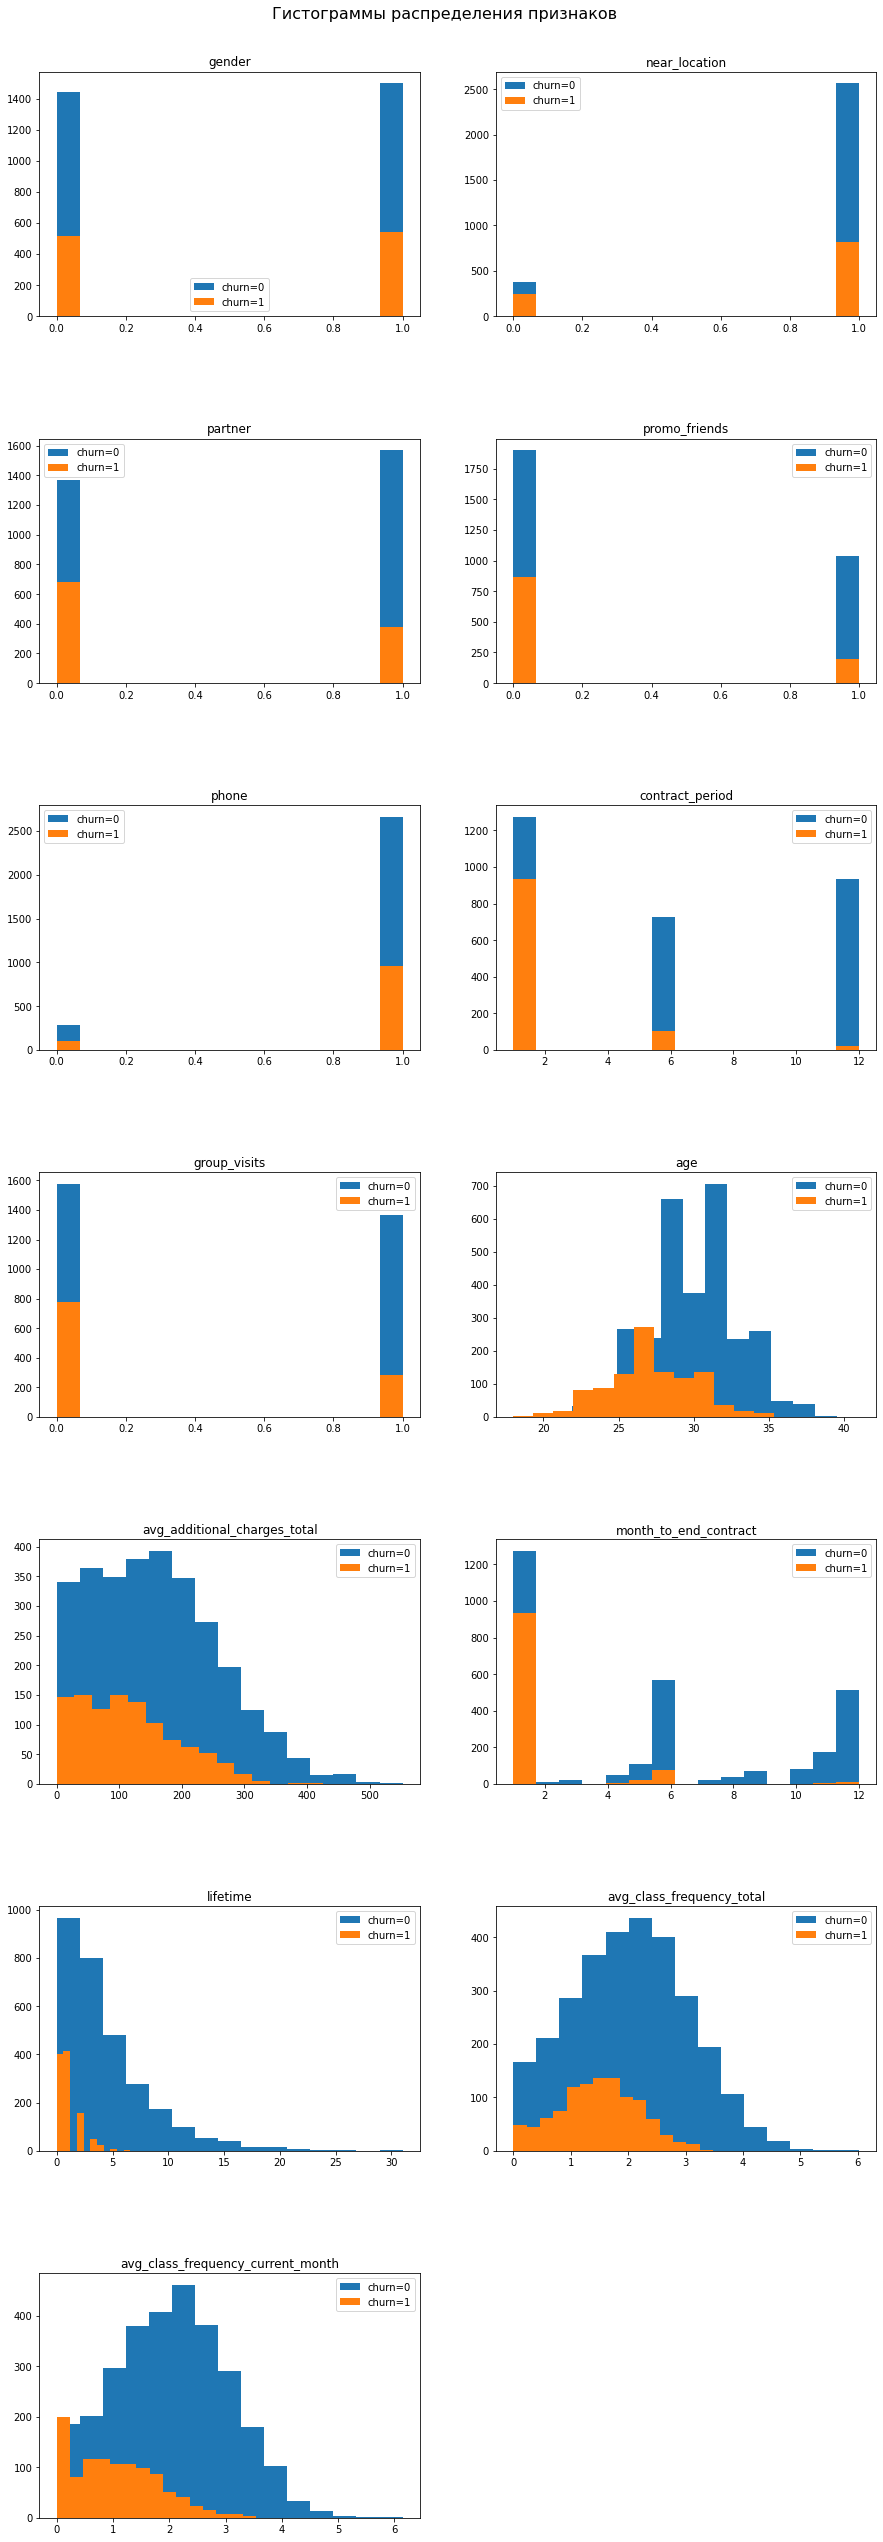

In [11]:
# посмотрим на распределение признаков в зависимости от разных значений целевой переменной

plt.figure(figsize=(15, 45))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Гистограммы распределения признаков', fontsize=16, y=0.9)

for n, col in enumerate(data.drop('churn', axis=1).columns):
    ax = plt.subplot(7, 2, n + 1)
    ax2 = data.query('churn==0').plot(
        kind='hist',
        y=col,
        bins=15,
        label='churn=0',
        ax=ax
    )
    data.query('churn==1').plot(
        kind='hist',
        y=col,
        bins=15,
        label='churn=1',
        ax=ax2,
    )
    ax.set_title(col)
    ax.set_ylabel('')

- Часть числовых признаков распределена близко к нормальному (age, avg_class_frequency_total, avg_class_frequency_current_month (для оставшихся клиентов), распределение avg_additional_charges_total, lifetime и avg_class_frequency_current_month (для ушедших клиентов) похоже на Пуассона
- Наблюдаются различия в распределении признаков для оставшися и ушедших клиентов, что позволяет построить модель предсказания оттока

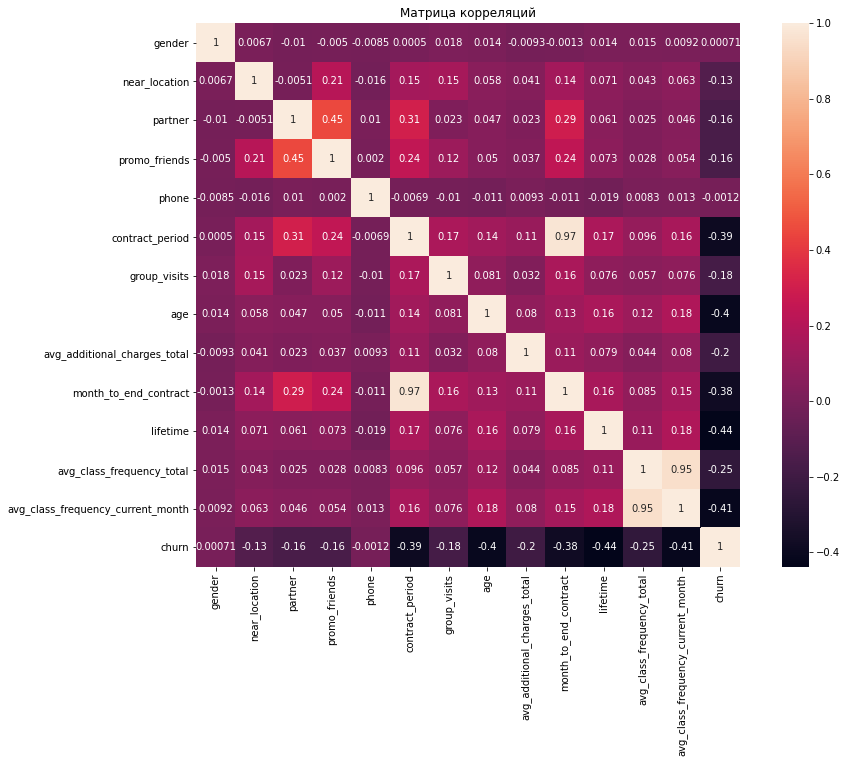

In [12]:
# построим матрицу корреляций
cm = data.corr()
fig, ax = plt.subplots(figsize=(15, 10))

#нарисуем тепловую карту 
sns.heatmap(cm, annot=True, square=True).set(title='Матрица корреляций')

plt.show()

- По матрице корреляций видно, что большая часть признаков не коррелирована, только 2 пары признаков очень сильно скоррелированы - avg_class_frequency_total и avg_class_frequency_current_month, month_to_end_contract и contract_period, что вполне ожидаемо ибо средняя посещаемость в текущем месяце отражается также в общей средней посещаемости, а количество месяцев до окончания контракта зависит от его срока

## Построение модели прогнозирования оттока пользователей <a name="model"></a>

- Построим модель бинарной классификации пользователей, где целевой признак — факт оттока пользователя в следующем месяце, воспользуемся алгоритмами логистической регрессии и случайного леса, сравним метрики accuracy, precision и recall
    - Сначала оставим все признаки, посмотрим на результаты автоматического прогноза с трешхолдом = 0.5 (ситуация, когда половина клиентов уходит в отток) и кастомного с трешхолдом = 0.7 (принимая во внимание факт несбалансированности классов - доля churn=0 составляет 73%, доля churn=1 - 27%, наша чтобы правильно отнести клиента к более редкому классу, нужно повысить порог вероятности для модели). Далее проделаем аналогичные шаги, убирая по одному признаку в паре скоррелированных
    - При модели прогноза оттока клиентов c точки зрения бизнеса нам нужно минимизировать количество false positive ситуаций, когда клиент на самом деле остается, а мы его обозначили как уходящего - потому что, цель - удержать клиента, что означает какие-то дополнительные затраты со стороны компании для этого удержания => с точки зрения метрик, нас больше всего интересует метрика precision. Конечно ситуация, когда мы пропускаем клиента, который уйдет, из-за неверного прогноза, тоже плохая, но тут уже встает вопрос сравнения потерь для компании в случае потери клиента vs затрат на его удержание

In [13]:
# подготовим функции

# функция для вывода метрик
def print_metrics(y_true, y_pred, title='Метрики классификации'):
    print(f'{title}')
    print('\tAccuracy: {:.3f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.3f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.3f}'.format(recall_score(y_true, y_pred)))

# функция для прогона моделей
def run_models(X):
    y = data['churn']
    # разделим модель на обучающую и валидационную выборку
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    # проведем стандартизацию признаков
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_st = scaler.transform(X_train)
    X_test_st = scaler.transform(X_test)

    # зададим модель логистической регрессии
    lr_model = LogisticRegression(random_state=0)
    lr_model.fit(X_train_st, y_train)
    lr_predictions = lr_model.predict(X_test_st)
    lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]

    # зададим модель на основе алгоритма случайного леса
    rf_model = RandomForestClassifier(n_estimators = 100, random_state=0)
    rf_model.fit(X_train, y_train)
    rf_predictions = rf_model.predict(X_test)
    rf_probabilities = rf_model.predict_proba(X_test)[:, 1]

    title = 'Автоматический прогноз'
    print(black(f'{title.center(100)}\n', 'bold'))

    print_metrics(
        y_test,
        lr_predictions,
        title='Метрики для модели логистической регрессии:'
    )

    print_metrics(
        y_test,
        rf_predictions,
        title='Метрики для модели случайного леса:'
    )

    # изменим трешхолд
    threshold = 0.7
    custom_lr_predictions = [0 if i < threshold else 1 for i in lr_probabilities]
    custom_rf_predictions = [0 if i < threshold else 1 for i in rf_probabilities]

    title = 'Custom прогноз'
    print(black(f'{title.center(100)}\n', 'bold'))

    print_metrics(
        y_test,
        custom_lr_predictions,
        title='Метрики для модели логистической регрессии:'
    )

    print_metrics(
        y_test,
        custom_rf_predictions,
        title='Метрики для модели случайного леса:'
    )

1.1 Оставляем пока мультиколлинеарность

In [14]:
# зададим матрицу признаков
X = data.drop('churn', axis = 1)

run_models(X)

                                       Автоматический прогноз                                       

Метрики для модели логистической регрессии:
	Accuracy: 0.922
	Precision: 0.854
	Recall: 0.828
Метрики для модели случайного леса:
	Accuracy: 0.916
	Precision: 0.839
	Recall: 0.818
                                           Custom прогноз                                           

Метрики для модели логистической регрессии:
	Accuracy: 0.935
	Precision: 0.951
	Recall: 0.778
Метрики для модели случайного леса:
	Accuracy: 0.897
	Precision: 0.908
	Recall: 0.652


- Логистическая регрессия в обоих случаях дает лучший результат
- Повышение трешхолда позволяет добиться более высокой метрики precision
- Лучшая модель - логистическая регрессия, custom прогноз

2.1.1 Уберем из каждой пары скореллированных признаков по одному - avg_class_frequency_total и month_to_end_contract

In [15]:
X = data.drop(['churn', 'avg_class_frequency_total', 'month_to_end_contract'], axis = 1)
run_models(X)

                                       Автоматический прогноз                                       

Метрики для модели логистической регрессии:
	Accuracy: 0.902
	Precision: 0.791
	Recall: 0.823
Метрики для модели случайного леса:
	Accuracy: 0.896
	Precision: 0.814
	Recall: 0.753
                                           Custom прогноз                                           

Метрики для модели логистической регрессии:
	Accuracy: 0.900
	Precision: 0.878
	Recall: 0.692
Метрики для модели случайного леса:
	Accuracy: 0.882
	Precision: 0.866
	Recall: 0.621


- Логистическая регрессия в обоих случаях дает лучший результат
- Повышение трешхолда позволяет добиться более высокой метрики precision, однако потеряли незначительно в accuracy
- Лучшая модель - логистическая регрессия, custom прогноз
- Однако при удалении скоррелированных признаков метрики немного ухудшились

2.2 Уберем из каждой пары скореллированных признаков по одному - avg_class_frequency_total и contract_period

In [16]:
X = data.drop(['churn', 'avg_class_frequency_total', 'contract_period'], axis = 1)
run_models(X)

                                       Автоматический прогноз                                       

Метрики для модели логистической регрессии:
	Accuracy: 0.905
	Precision: 0.799
	Recall: 0.823
Метрики для модели случайного леса:
	Accuracy: 0.906
	Precision: 0.825
	Recall: 0.788
                                           Custom прогноз                                           

Метрики для модели логистической регрессии:
	Accuracy: 0.900
	Precision: 0.873
	Recall: 0.697
Метрики для модели случайного леса:
	Accuracy: 0.881
	Precision: 0.860
	Recall: 0.621


- Логистическая регрессия в обоих случаях дает лучший результат
- Повышение трешхолда позволяет добиться более высокой метрики precision, однако снова потеряли в accuracy
- Лучшая модель - логистическая регрессия, custom прогноз
- Вновь, метрики моделей со всеми признаками - лучше

2.3 Уберем из каждой пары скореллированных признаков по одному - avg_class_frequency_current_month и month_to_end_contract

In [17]:
X = data.drop(['churn', 'avg_class_frequency_current_month', 'month_to_end_contract'], axis = 1)
run_models(X)

                                       Автоматический прогноз                                       

Метрики для модели логистической регрессии:
	Accuracy: 0.899
	Precision: 0.788
	Recall: 0.808
Метрики для модели случайного леса:
	Accuracy: 0.890
	Precision: 0.784
	Recall: 0.768
                                           Custom прогноз                                           

Метрики для модели логистической регрессии:
	Accuracy: 0.892
	Precision: 0.864
	Recall: 0.672
Метрики для модели случайного леса:
	Accuracy: 0.885
	Precision: 0.873
	Recall: 0.626


- Логистическая регрессия в обоих случаях дает лучший результат
- Повышение трешхолда позволяет добиться более высокой метрики precision, однако снова потеряли в accuracy
- Лучшая модель - логистическая регрессия, custom прогноз
- Вновь, метрики моделей со всеми признаками - лучше

2.4 Уберем из каждой пары скореллированных признаков по одному - avg_class_frequency_current_month и contract_period

In [18]:
X = data.drop(['churn', 'avg_class_frequency_current_month', 'contract_period'], axis = 1)
run_models(X)

                                       Автоматический прогноз                                       

Метрики для модели логистической регрессии:
	Accuracy: 0.897
	Precision: 0.784
	Recall: 0.808
Метрики для модели случайного леса:
	Accuracy: 0.896
	Precision: 0.801
	Recall: 0.773
                                           Custom прогноз                                           

Метрики для модели логистической регрессии:
	Accuracy: 0.892
	Precision: 0.873
	Recall: 0.662
Метрики для модели случайного леса:
	Accuracy: 0.881
	Precision: 0.860
	Recall: 0.621


- Логистическая регрессия в обоих случаях дает лучший результат
- Повышение трешхолда позволяет добиться более высокой метрики precision, однако снова потеряли в accuracy
- Лучшая модель - логистическая регрессия, custom прогноз
- Вновь, метрики моделей со всеми признаками - лучше

Вывод - лучшей моделью признаем модель со всеми признаками, построенную с помощью алгоритма логистической регрессии и кастомным трешхолдом в 0.7

## Кластеризация пользователей <a name="cluster"></a>

In [19]:
X = data.drop('churn', axis = 1)

# стандартизируем данные
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward')

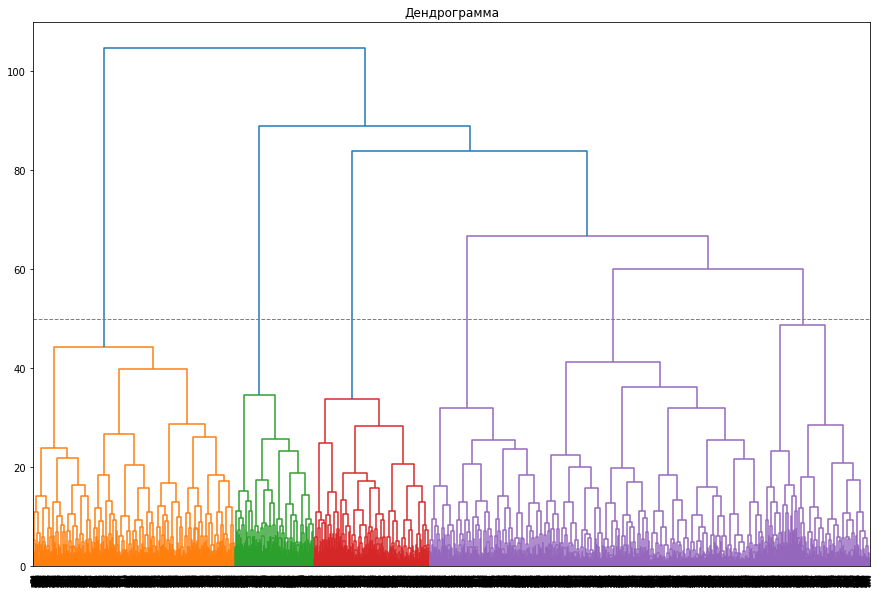

In [20]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.axhline(y=50, c='grey', lw=1, linestyle='dashed')
plt.title('Дендрограмма')
plt.show()

- Визуально можно разделить пользователей на 6 кластеров (если провести линию на уровне 50)
- Однако, продолжим с 5 кластерами, как указано в задании

In [21]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(X_sc)

# сохраняем метки кластера в поле нашего датасета
data['cluster_km'] = labels
clusters = data.groupby(['cluster_km']).mean()
clusters

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.50,0.96,0.78,0.57,1.00,10.89,0.54,29.98,160.76,9.95,4.74,1.98,1.97,0.03
1,0.52,0.86,0.47,0.31,0.00,4.79,0.43,29.30,143.96,4.48,3.92,1.85,1.72,0.27
2,0.50,0.00,0.46,0.08,1.00,2.35,0.22,28.48,135.46,2.20,2.81,1.66,1.48,0.44
3,0.49,1.00,0.35,0.24,1.00,1.95,0.34,28.17,131.62,1.86,2.44,1.25,1.01,0.51
4,0.56,0.98,0.36,0.23,1.00,2.67,0.47,30.13,161.66,2.46,4.90,2.85,2.85,0.07


Соберем наблюдения в таблицу:

| Столбец | Наблюдение | 
| :-----|:--------------------|
| gender| Кластеры примерно похожы по соотношению мужчин и женщин, кроме кластера 4 с небольшим преимуществом одного из полов (если предполагаем, что 1 - женщины, то преваливует женский пол) |
| near_location| Кластер 2 явно выделяется по удаленности от фитнес-центра|
| partner| В кластере 0 больше клиентов из партнерских организаций| 
| promo_friends| В кластере 0 больше людей пришли по промо, в кластере 2 - очень мало таких клиентов | 
| phone| Кластер 1 не предоставляет номер телефона | 
| contract_period| Кластер 0 - закупает самые длинные контракты (можно предположить, что у партнерских организаций более выгодные предложения + при приглашении друга даются дополнительные скидки) | 
| group_visits| Практически во всех кластерах больше людей, не ходящих на групповые занятия (кроме 0, там их превалирование незначительно)| 
| age| По среднему возрасту все кластеры очень близки | 
| avg_additional_charges_total| Больше всего доп выручка от кластера 4 (женщин там немного больше, они охотнее пользуются услугами косметического салона) и 0 (скорее всего клиенты тратят там сохраненные деньги от более выгодных условий контракта) | 
| month_to_end_contract| Прямая связь со сроком контракта | 
| lifetime| Кластер 4 - пришли раньше всех| 
| avg_class_frequency_total| В среднем все кластеры посещают фитнес от 1 до 2 раз в неделю, кластер 4 немного выделяется | 
| avg_class_frequency_current_month| Аналогичная ситуация в текущем месяце| 
| churn| Меньше всего клиентов ушло в кластере 0 (практически никто), больше всего - в кластере 3, с самым коротким контрактом| 

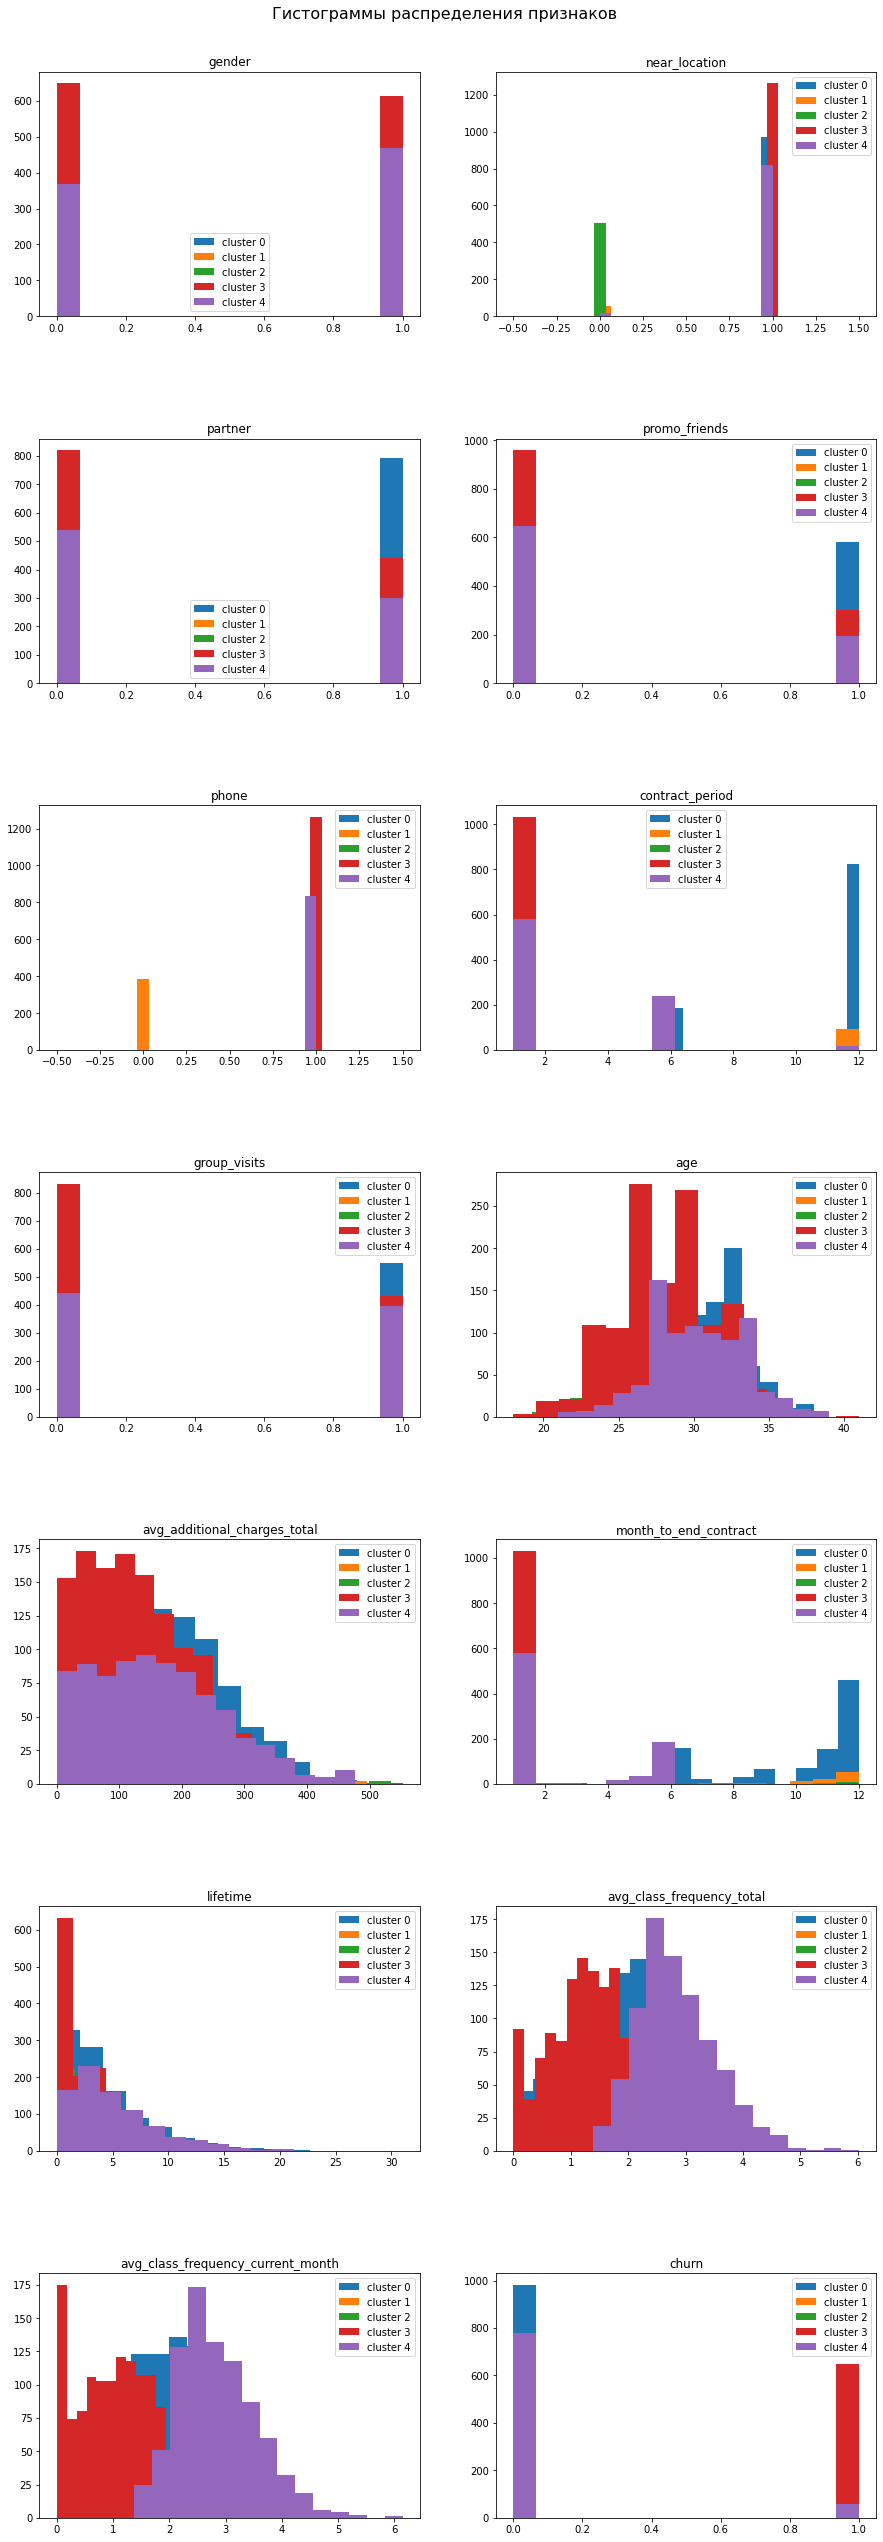

In [22]:
# посмотрим на распределение признаков по кластерам

plt.figure(figsize=(15, 45))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Гистограммы распределения признаков', fontsize=16, y=0.9)

for n, col in enumerate(data.drop('cluster_km', axis=1).columns):
    ax = plt.subplot(7, 2, n + 1)
    ax0 = data.query('cluster_km==0').plot(
        kind='hist',
        y=col,
        bins=15,
        label='cluster 0',
        ax=ax
    )
    ax1 = data.query('cluster_km==1').plot(
        kind='hist',
        y=col,
        bins=15,
        label='cluster 1',
        ax=ax0
    )
    ax2 = data.query('cluster_km==2').plot(
        kind='hist',
        y=col,
        bins=15,
        label='cluster 2',
        ax=ax1
    )
    ax3 = data.query('cluster_km==3').plot(
        kind='hist',
        y=col,
        bins=15,
        label='cluster 3',
        ax=ax2
    )
    data.query('cluster_km==4').plot(
        kind='hist',
        y=col,
        bins=15,
        label='cluster 4',
        ax=ax3,
    )
    ax.set_title(col)
    ax.set_ylabel('')

- Есть небольшие отличия в распределении признаков по кластерам
    - в глаза бросается удаленность средняя посещаемость - тип распределений для кластеров отличается, если у 4го более менее близок к нормальному, то у 3го явно скошен в сторону меньшей посещаемости

In [23]:
# посчитаем долю оттока по кластерам

print(black(f'Доля оттока по кластерам: \n','bold'))

data1=data.groupby('cluster_km').count()
data1=data1[['churn']]
data2=data.query('churn==1').groupby('cluster_km').count()
data2=data2[['churn']]
data3=data1.merge(data2, on='cluster_km', how='left')
data3.columns=['clients_count', 'churn=1']
data3['churn_share'] = data3['churn=1']/data3['clients_count']
data3.style.format({'churn_share': "{:.2%}"})

Доля оттока по кластерам: 



,clients_count,churn=1,churn_share
cluster_km,,,
0,1010,28,2.77%
1,385,103,26.75%
2,505,224,44.36%
3,1262,649,51.43%
4,838,57,6.80%


- Наиболее подвержен оттоку кластер 3, самые лояльные клиенты находятся в кластере 0 и 4

## Выводы и рекомендации <a name="results"></a>

- В ходе выполненного анализа была выбрана модель наиболее лучшим образом прогнозирующая отток клиентов фитнес-центра на уровне следующего месяца - модель со всеми имеющимися признаками, построенную с помощью алгоритма логистической регрессии и кастомным трешхолдом в 0.7
- В ходе решения задачи кластеризации клиентов были выявлены 5 кластеров клиентов
    - В кластере 0 клиенты в основном из партнерских организаций, приходят по промо "приведи друга", заключают долгосрочные контракты, меньше всего подвержены оттоку
    - Явной чертой кластера 1 является тот факт, что они не предоставляют свой номер телефона
    - Кластер 2 явно выделяется по удаленности от фитнес-центра
    - Кластер 3 - самый многочисленный, имеет самые короткие контракты, находится ближе всего к фитнес-центрам, больше всего подвержены оттоку
    - Кластер 4 - превалирует женский пол, чаще посещают фитнес-центр
- Можно сделать заключение, что основным фактором, влияющим на отток, является длительность контракта - клиенты с более коротким контрактом изначально не настроены долго оставаться
- Как шаги для сокращения оттока и улучшения качества взаимодействия с клиентами можно предложить следующее
    - Пересмотреть условия контрактов - явно виден перекос в сторону выгодных условий для партнерских организаций, можно предложить систему скидок/бонусов на долгосрочные контракты "простым" клиентам
    - За предоставление телефона можно давать бонусы, которые потом можно использовать в качестве оплаты доп услуг
    - Ближе к окончанию контракта можно связаться с клиентом, и предложить более выгодные условия как уже постоянному клиенту
    - Стоит пересмотреть предоставляемые групповые занятия - возможно предложение не сходится с запросами клиентов, поэтому они не пользуются такой большой популярностью - как вариант, короткий опрос при заключении контракта, где можно попросить клиента указать, какие групповые занятия ему интересны
    - Нужно поддержать посещаемость клиентов - устроить соревнование между клиентами, кто чаще ходит, в качестве подарка дать бесплатные месяцы/возможность получения какой-то услуги бесплатно на короткий срок/ продление контракта, либо устроить бонусную систему, за каждое посещение давать баллы, в конце месяца их можно использовать в кафе фитнес-центра